## ABC

In [1]:
import sys
import os

# Add the parent directory (lfi) to sys.path
sys.path.insert(0, os.path.abspath('..'))

# Now try importing your local lfi package
import lfi
import lfi.simulators
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

#print("lfi package imported successfully")


2024-12-04 12:30:05.675 | INFO     | lfi.config:<module>:11 - PROJ_ROOT path is: /home/givasile/github/projects/sbi


In [2]:
np.random.seed(7)

In [3]:
linear_sim = lfi.simulators.LinearSimulator(sigma_noise=0.1)
uniform_prior = lfi.simulators.UniformPrior(-2, 2, dim=2)

In [4]:
x_obs = np.random.normal(size=(2,))
print(f"X fixed value is: {x_obs}")
y_obs = np.array(0.3)

X fixed value is: [ 1.6905257  -0.46593737]


In [5]:
import sbi

In [6]:
from sbi.utils import BoxUniform
import torch

num_dim = 3
prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

In [7]:
np.e**prior.log_prob(torch.Tensor([[0.2, 0.1, 0.0], [0.2, -1, -2.1]]))

tensor([0.0156, 0.0000])

In [23]:
sim = lfi.simulators.GaussianNoise(0.1)
sim.sample_pytorch(prior.sample_n(3))

/tmp/ipykernel_5480/3411582241.py:2: FutureWarning: `sample_n(n)` will be deprecated. Use `sample((n,))` instead.
  sim.simulate_pytorch(prior.sample_n(3))


tensor([[-0.9941, -0.7007, -1.8647],
        [ 1.7147,  2.0171, -1.5701],
        [-0.2339, -1.0029, -1.0326]])

In [24]:
from sbi.inference import MCABC
x_obs = np.array([-1., -1, 1])
inference_method = MCABC(prior=prior, simulator=sim.sample_pytorch)
theta_samples = inference_method(x_o=x_obs, num_simulations=1000, quantile=.1)
theta_posterior = inference_method(x_o=x_obs, num_simulations=1000, quantile=.1, kde=True)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

(<Figure size 1000x1000 with 9 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >],
        [<Axes: xlabel='dim 1'>, <Axes: xlabel='dim 2'>,
         <Axes: xlabel='dim 3'>]], dtype=object))

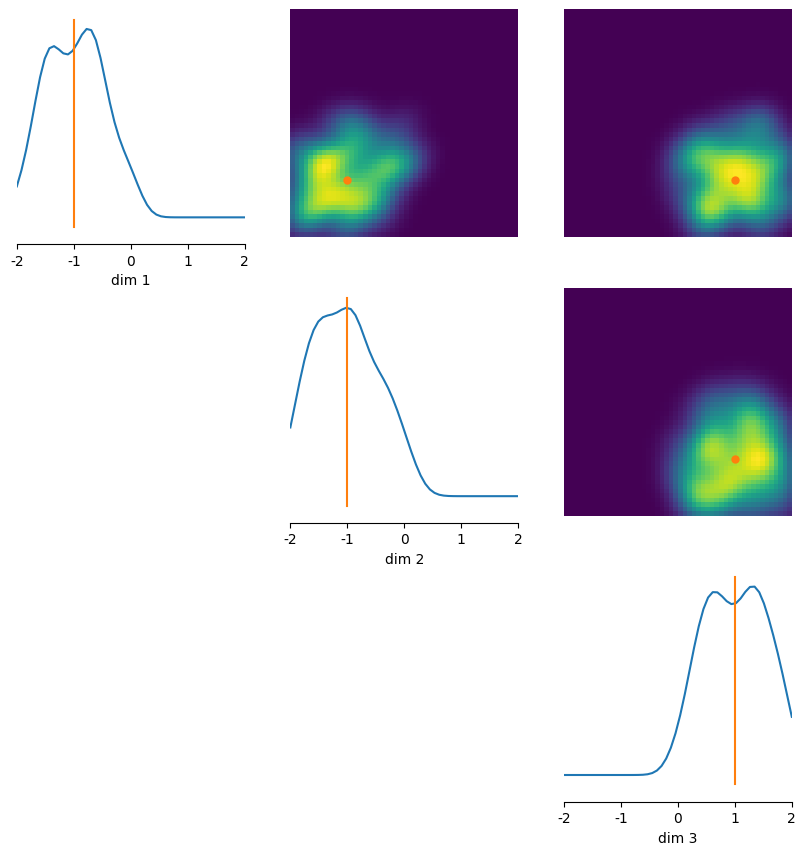

In [31]:
from sbi.analysis import pairplot
pairplot(samples=theta_samples, points=np.expand_dims(x_obs, 0), upper="kde", diag="kde", limits= torch.tensor([[-2., 2.]] * 3))

In [ ]:
theta_posterior.samp

In [5]:
import lfi.models.abc
abc_inference1 = lfi.models.abc.ABCInference(x=x_obs, obs=y_obs)
samples_pos1 = abc_inference1.infer(target_samples=100, Nsamples=10000, simulator_func=linear_sim.sample_numpy, prior=uniform_prior.sample_numpy)
abc_inference2 = lfi.models.abc.ABCInference(x=x_obs, obs=y_obs, eps=0.05)
samples_pos2 = abc_inference2.infer(target_samples=100, Nsamples=10000, batch_size=100, simulator_func=linear_sim.sample_numpy, prior=uniform_prior.sample_numpy)


The final step is: 7600


In [6]:
print (f" The number of posterior samples 1 is : {samples_pos1.shape[0]}\n")
print(f"The mean value of posterior 1 is : {samples_pos1.mean(axis=0)}\n")
print(f"The standard deviation of posterior 1 is : {samples_pos1.std(axis=0)}")

print("--"*50)
print(f"The number of posterior samples 2 is : {samples_pos2.shape[0]}\n")
print(f"The mean value of posterior 2 is : {samples_pos2.mean(axis=0)}\n")
print(f"The standard deviation of posterior 2 is : {samples_pos2.std(axis=0)}")

 The number of posterior samples 1 is : 100

The mean value of posterior 1 is : [ 0.0080046  -0.18434891]

The standard deviation of posterior 1 is : [0.30700174 1.1106974 ]
----------------------------------------------------------------------------------------------------
The number of posterior samples 2 is : 100

The mean value of posterior 2 is : [ 0.15002185 -0.14426199]

The standard deviation of posterior 2 is : [0.31107616 1.1569337 ]


In [7]:
print(samples_pos2.min(axis=0))
print(samples_pos2.max(axis=0))

[-0.37534964 -1.9923075 ]
[0.75693727 1.9098008 ]


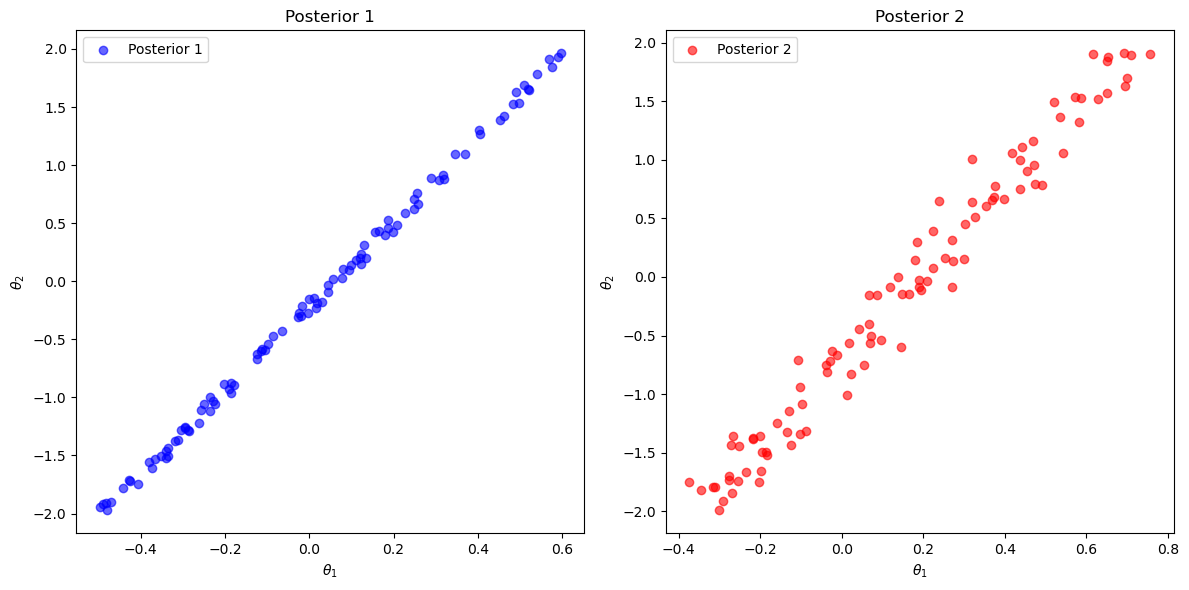

In [8]:
# Plot figures
import matplotlib.pyplot as plt

# Plot figures
fig, axes = plt.subplots(1,2, figsize=(12,6)) 

# Scatter plots for the posteriors from abc_methods
axes[0].scatter(samples_pos1[:,0], samples_pos1[:,1], alpha = 0.6, color='blue', label='Posterior 1')
axes[0].set_title('Posterior 1')
axes[0].set_xlabel(r"$\theta_1$")
axes[0].set_ylabel(r"$\theta_2$")
axes[0].legend()

axes[1].scatter(samples_pos2[:, 0], samples_pos2[:, 1], alpha = 0.6, color='red', label='Posterior 2')
axes[1].set_title('Posterior 2')
axes[1].set_xlabel(r"$\theta_1$")
axes[1].set_ylabel(r"$\theta_2$")
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
key = random.PRNGKey(42)
samples_pos1_jax = abc_inference1.infer(target_samples=100, Nsamples=10000, simulator_func=linear_sim.sample_jax, prior=uniform_prior.sample_jax, key=key)
samples_pos2_jax = abc_inference2.infer(target_samples=100, Nsamples=10000, batch_size=100, simulator_func = linear_sim.sample_jax, prior=uniform_prior.sample_jax, key=key)


The final step is: 6600


In [10]:
print (f" The number of posterior samples 1 is : {samples_pos1_jax.shape[0]}\n")
print(f"The mean value of posterior 1 is : {samples_pos1_jax.mean(axis=0)}\n")
print(f"The standard deviation of posterior 1 is : {samples_pos1_jax.std(axis=0)}")

print("--"*50)
print(f"The number of posterior samples 2 is : {samples_pos2_jax.shape[0]}\n")
print(f"The mean value of posterior 2 is : {samples_pos2_jax.mean(axis=0)}\n")
print(f"The standard deviation of posterior 2 is : {samples_pos2_jax.std(axis=0)}")

 The number of posterior samples 1 is : 100

The mean value of posterior 1 is : [0.18163593 0.04634067]

The standard deviation of posterior 1 is : [0.32994577 1.1926486 ]
----------------------------------------------------------------------------------------------------
The number of posterior samples 2 is : 100

The mean value of posterior 2 is : [0.19420952 0.04666616]

The standard deviation of posterior 2 is : [0.3141789 1.1436533]


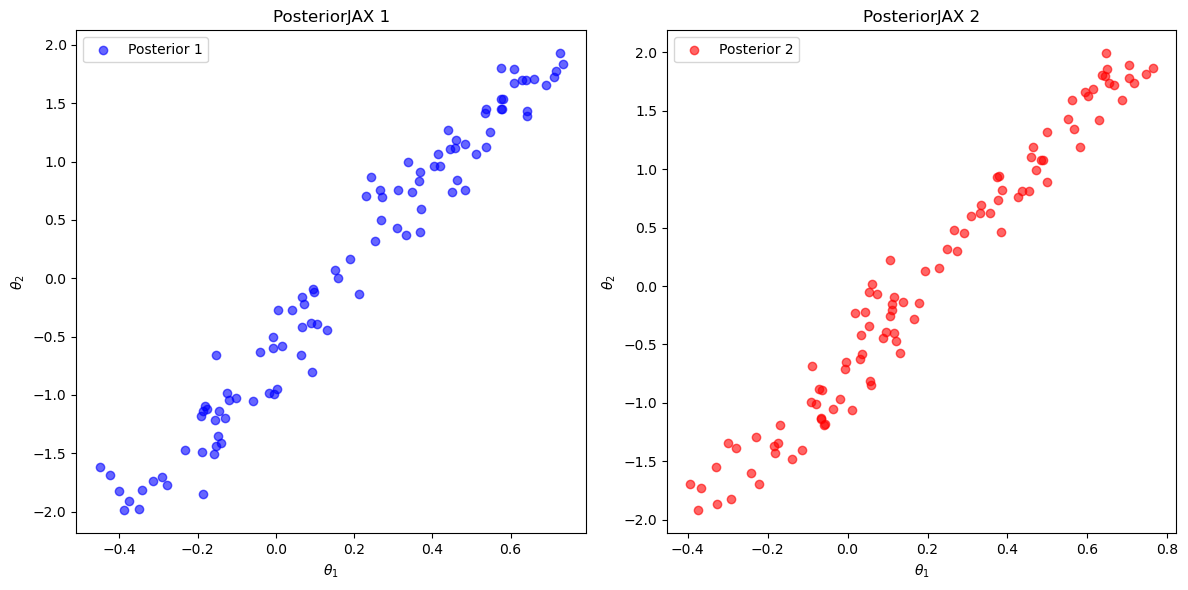

In [11]:
# Plot figures
import matplotlib.pyplot as plt

# Plot figures
fig, axes = plt.subplots(1,2, figsize=(12,6)) 

# Scatter plots for the posteriors from abc_methods
axes[0].scatter(samples_pos1_jax[:,0], samples_pos1_jax[:,1], alpha = 0.6, color='blue', label='Posterior 1')
axes[0].set_title('PosteriorJAX 1')
axes[0].set_xlabel(r"$\theta_1$")
axes[0].set_ylabel(r"$\theta_2$")
axes[0].legend()

axes[1].scatter(samples_pos2_jax[:, 0], samples_pos2_jax[:, 1], alpha = 0.6, color='red', label='Posterior 2')
axes[1].set_title('PosteriorJAX 2')
axes[1].set_xlabel(r"$\theta_1$")
axes[1].set_ylabel(r"$\theta_2$")
axes[1].legend()

plt.tight_layout()
plt.show()


## SMC

In [12]:
import lfi.models.smc

In [18]:
tolerance_sequence=[0.1, 0.05, 0.01] 

abc_inference_smc = lfi.models.smc.SMC(x=x_obs, obs=y_obs)
results = abc_inference_smc.smc_algorithm(tolerance_sequence = tolerance_sequence,
                                          target_samples = 100,
                                          Nsamples = 10_000,
                                          prior = uniform_prior.sample_numpy,
                                          simulator_func = linear_sim.sample_numpy)

Starting SMC for epsilon: 0.1
Running SMC for epsilon=0.05
Running SMC for epsilon=0.01


In [19]:
print(f"Eps: {results[0]['epsilon']} - Mean Pos Value: {results[0]['samples_pos'].mean(axis=0)} - STD: {results[0]['samples_pos'].std(axis=0)}")
print(f"Eps: {results[1]['epsilon']} - Mean Pos Value: {results[1]['samples_pos'].mean(axis=0)} - STD: {results[1]['samples_pos'].std(axis=0)}")
print(f"Eps: {results[2]['epsilon']} - Mean Pos Value: {results[2]['samples_pos'].mean(axis=0)} - STD: {results[2]['samples_pos'].std(axis=0)}")

Eps: 0.1 - Mean Pos Value: [0.24557906 0.07866358] - STD: [0.32751372 1.1689855 ]
Eps: 0.05 - Mean Pos Value: [0.24559523 0.09585087] - STD: [0.32361725 1.1852423 ]
Eps: 0.01 - Mean Pos Value: [ 0.11590802 -0.26630738] - STD: [0.33382806 1.2082509 ]


In [20]:
print(len(results[2]['samples_pos']))

100


In [21]:
print(results[2]['samples_pos'].min(axis = 0))
print(results[2]['samples_pos'].max(axis = 0))

[-0.33196038 -1.8859214 ]
[0.71244276 1.8896965 ]


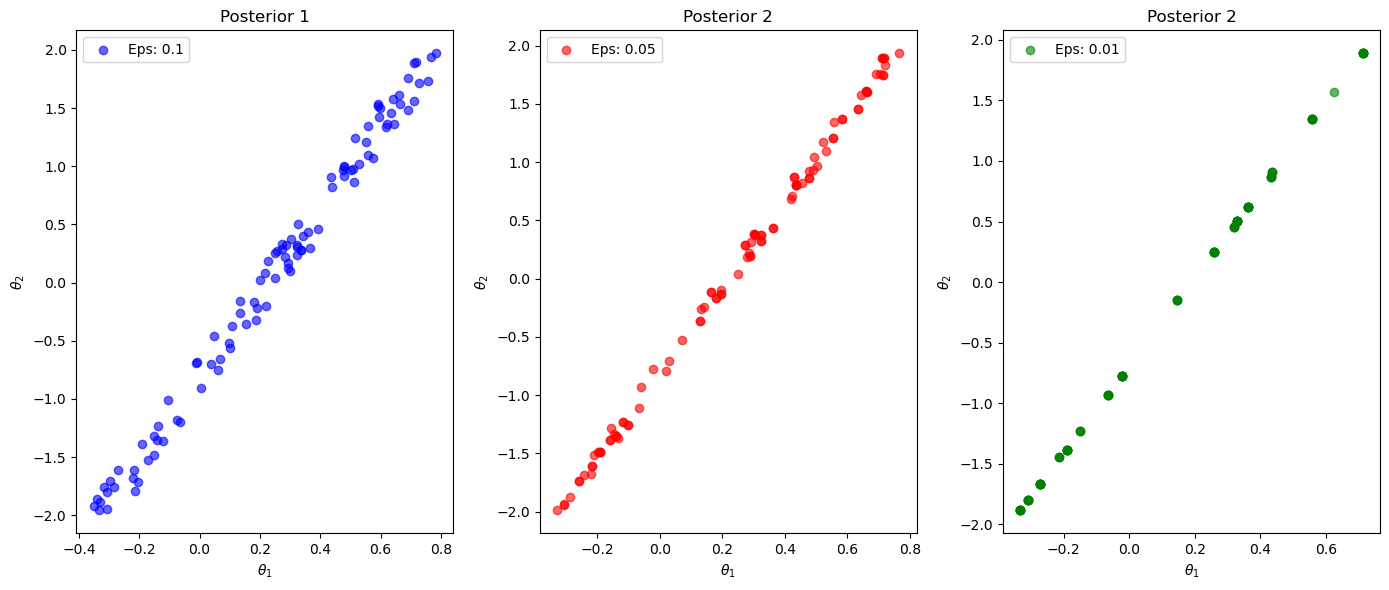

In [22]:
# Plot figures
import matplotlib.pyplot as plt

# Plot figures
fig, axes = plt.subplots(1,3, figsize=(14,6)) 

# Scatter plots for the posteriors from abc_methods
axes[0].scatter(results[0]['samples_pos'][:,0], results[0]['samples_pos'][:,1], alpha = 0.6, color='blue', label=f"Eps: {results[0]['epsilon']}")
axes[0].set_title('Posterior 1')
axes[0].set_xlabel(r"$\theta_1$")
axes[0].set_ylabel(r"$\theta_2$")
axes[0].legend()

axes[1].scatter(results[1]['samples_pos'][:,0], results[1]['samples_pos'][:,1], alpha = 0.6, color='red', label=f"Eps: {results[1]['epsilon']}")
axes[1].set_title('Posterior 2')
axes[1].set_xlabel(r"$\theta_1$")
axes[1].set_ylabel(r"$\theta_2$")
axes[1].legend()

axes[2].scatter(results[2]['samples_pos'][:,0], results[2]['samples_pos'][:,1], alpha = 0.6, color='green', label=f"Eps: {results[2]['epsilon']}")
axes[2].set_title('Posterior 2')
axes[2].set_xlabel(r"$\theta_1$")
axes[2].set_ylabel(r"$\theta_2$")
axes[2].legend()

plt.tight_layout()
plt.show()


In [23]:
import lfi.models.smc

In [24]:
key = random.PRNGKey(42)
tolerance_sequence=[0.1, 0.05, 0.01] 

abc_inference_smc_jax = lfi.models.smc.SMC_JAX(x=x_obs, obs=y_obs)
results_jax = abc_inference_smc_jax.smc_algorithm(tolerance_sequence = tolerance_sequence,
                                                  target_samples = 100,
                                                  Nsamples = 10_000,
                                                  prior = uniform_prior.sample_jax,
                                                  simulator_func = linear_sim.sample_jax,
                                                  key=key)

Starting SMC for epsilon: 0.1
Running SMC for epsilon=0.05
Running SMC for epsilon=0.01


In [25]:
print(f"Eps: {results_jax[0]['epsilon']} - Mean Pos Value: {results_jax[0]['samples_pos'].mean(axis=0)} - STD: {results_jax[0]['samples_pos'].std(axis=0)}")
print(f"Eps: {results_jax[1]['epsilon']} - Mean Pos Value: {results_jax[1]['samples_pos'].mean(axis=0)} - STD: {results_jax[1]['samples_pos'].std(axis=0)}")
print(f"Eps: {results_jax[2]['epsilon']} - Mean Pos Value: {results_jax[2]['samples_pos'].mean(axis=0)} - STD: {results_jax[2]['samples_pos'].std(axis=0)}")

Eps: 0.1 - Mean Pos Value: [ 0.17273895 -0.00108949] - STD: [0.2888686 1.0543591]
Eps: 0.05 - Mean Pos Value: [0.18742482 0.04750749] - STD: [0.31870854 1.1160917 ]
Eps: 0.01 - Mean Pos Value: [ 0.1616122  -0.07179273] - STD: [0.34333175 1.2351346 ]


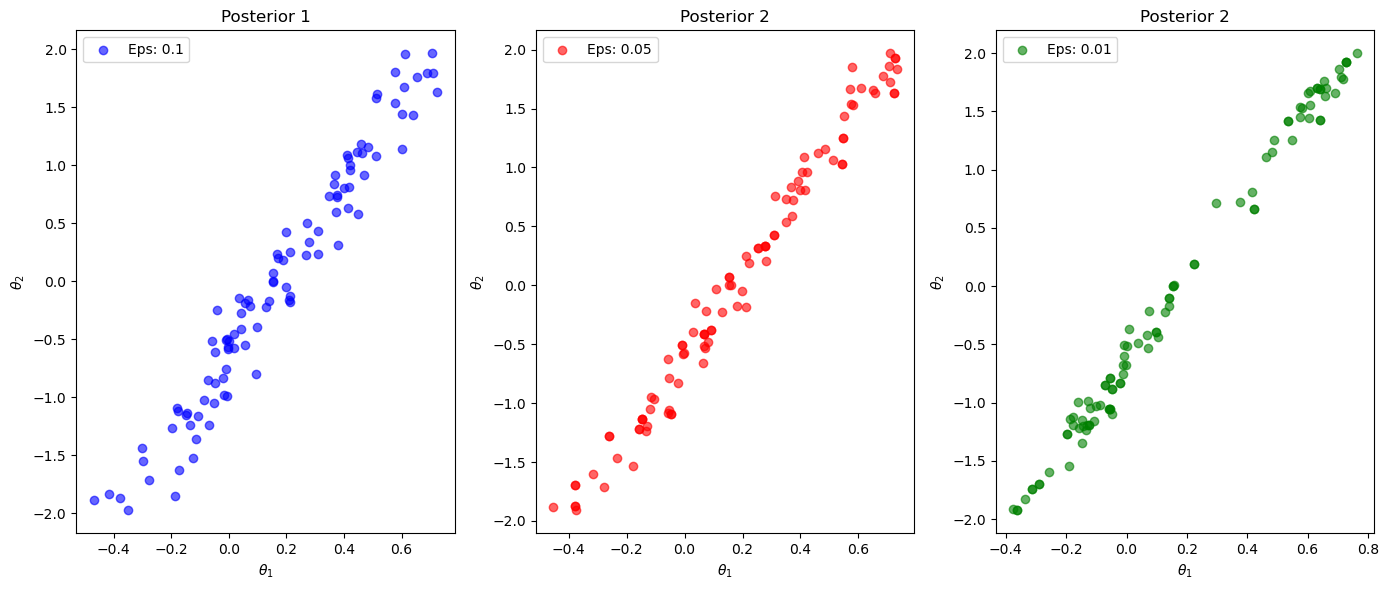

In [26]:
# Plot figures
import matplotlib.pyplot as plt

# Plot figures
fig, axes = plt.subplots(1,3, figsize=(14,6)) 

# Scatter plots for the posteriors from abc_methods
axes[0].scatter(results_jax[0]['samples_pos'][:,0], results_jax[0]['samples_pos'][:,1], alpha = 0.6, color='blue', label=f"Eps: {results[0]['epsilon']}")
axes[0].set_title('Posterior 1')
axes[0].set_xlabel(r"$\theta_1$")
axes[0].set_ylabel(r"$\theta_2$")
axes[0].legend()

axes[1].scatter(results_jax[1]['samples_pos'][:,0], results_jax[1]['samples_pos'][:,1], alpha = 0.6, color='red', label=f"Eps: {results[1]['epsilon']}")
axes[1].set_title('Posterior 2')
axes[1].set_xlabel(r"$\theta_1$")
axes[1].set_ylabel(r"$\theta_2$")
axes[1].legend()

axes[2].scatter(results_jax[2]['samples_pos'][:,0], results_jax[2]['samples_pos'][:,1], alpha = 0.6, color='green', label=f"Eps: {results[2]['epsilon']}")
axes[2].set_title('Posterior 2')
axes[2].set_xlabel(r"$\theta_1$")
axes[2].set_ylabel(r"$\theta_2$")
axes[2].legend()

plt.tight_layout()
plt.show()


In [35]:
print(results_jax[2]['samples_pos'].min(axis = 0))
print(results_jax[2]['samples_pos'].max(axis = 0))

[-0.37670088 -1.9261451 ]
[0.76199055 1.9991403 ]


## OMC

In [15]:
import numpy as np
from lfi.simulators import prior, simulator_omc
from lfi.models.omc import OMCInference

ModuleNotFoundError: No module named 'simulators'

In [4]:
# Define the dimensions and number of samples
N=10000
theta_dim, u_dim = 5, 5 # Dimensions of theta, # Dimension of nuisance variables

# Observation
y_obs = np.full(theta_dim, 0.3) # Assuming y has the same dimension as simulator output
np.random.seed(42)

# Fixed x from a uniform distribution
x_fixed = np.random.uniform(-1,1, theta_dim)

# Sampling thetas from the prior
theta_pr = prior(N, theta_dim)

# Run Inference 
omc_inference = OMCInference(theta_pr, y_obs, x_fixed, u_dim)
samples_pos, weights = omc_inference.infer()
print(f"The number of samples is: {samples_pos.shape[0]}")

# Calculate weighted mean and std for each dimnensioin of theta
weighted_mean = np.average(samples_pos, weights = weights, axis=0)
weighted_variance = np.average((samples_pos - weighted_mean)**2, weights = weights, axis=0)
weighted_std = np.sqrt(weighted_variance)

print(f"The mean value of the posterior distribution is: {weighted_mean}")
print(f"The standard deviation of the posterior distribution is: {weighted_std}")

The number of samples is: 10000
The mean value of the posterior distribution is: [ 0.00538229 -0.02723251 -0.00138771  0.01190336 -0.01144511]
The standard deviation of the posterior distribution is: [1.15842172 1.15358599 1.15297844 1.15212796 1.15044569]


In [5]:
weights.shape

(10000,)

In [7]:
y_obs

array([0.3, 0.3, 0.3, 0.3, 0.3])

In [9]:
theta_pr.shape

(10000, 5)

In [10]:
non_zero_mask = weights>0
filtered_samples = samples_pos[non_zero_mask]
filtered_weights = weights[non_zero_mask]
print(f"The number of the non-negative samples are: {filtered_samples.shape}")

The number of the non-negative samples are: (10000, 5)
